In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd



In [ ]:
# Data to be used
df = pd.read_csv('training_data_with_weather_info_week_4.csv')
continent_map_df = pd.read_csv('Continents.csv')

In [3]:
df.head()

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,country+province,Lat,Long,day_from_jan_first,...,min,max,stp,slp,dewp,rh,ah,wdsp,prcp,fog
0,1,Afghanistan,NaN,2020-01-22,0.0,0.0,Afghanistan-,33.0,65.0,22,...,33.6,54.9,999.9,1024.3,27.4,0.545709,0.186448,9.4,0.00,0
1,2,Afghanistan,NaN,2020-01-23,0.0,0.0,Afghanistan-,33.0,65.0,23,...,32.7,55.9,999.9,1020.8,22.8,0.461259,0.163225,14.9,99.99,1
2,3,Afghanistan,NaN,2020-01-24,0.0,0.0,Afghanistan-,33.0,65.0,24,...,36.9,43.2,999.9,1018.6,34.5,0.801794,0.325375,10.4,0.17,1
3,4,Afghanistan,NaN,2020-01-25,0.0,0.0,Afghanistan-,33.0,65.0,25,...,37.9,56.3,999.9,1018.0,37.8,0.728175,0.214562,6.1,0.57,1
4,5,Afghanistan,NaN,2020-01-26,0.0,0.0,Afghanistan-,33.0,65.0,26,...,36.1,53.1,999.9,1014.8,33.2,0.685513,0.231656,10.8,0.00,1


<hr style="fill: 1px solid white;">
<font face="Arial" size="5.5"> DISTRIBUTION OF MEDIAN TEMPERATURE OF COUNTRIES BY CONTINENT: </font>

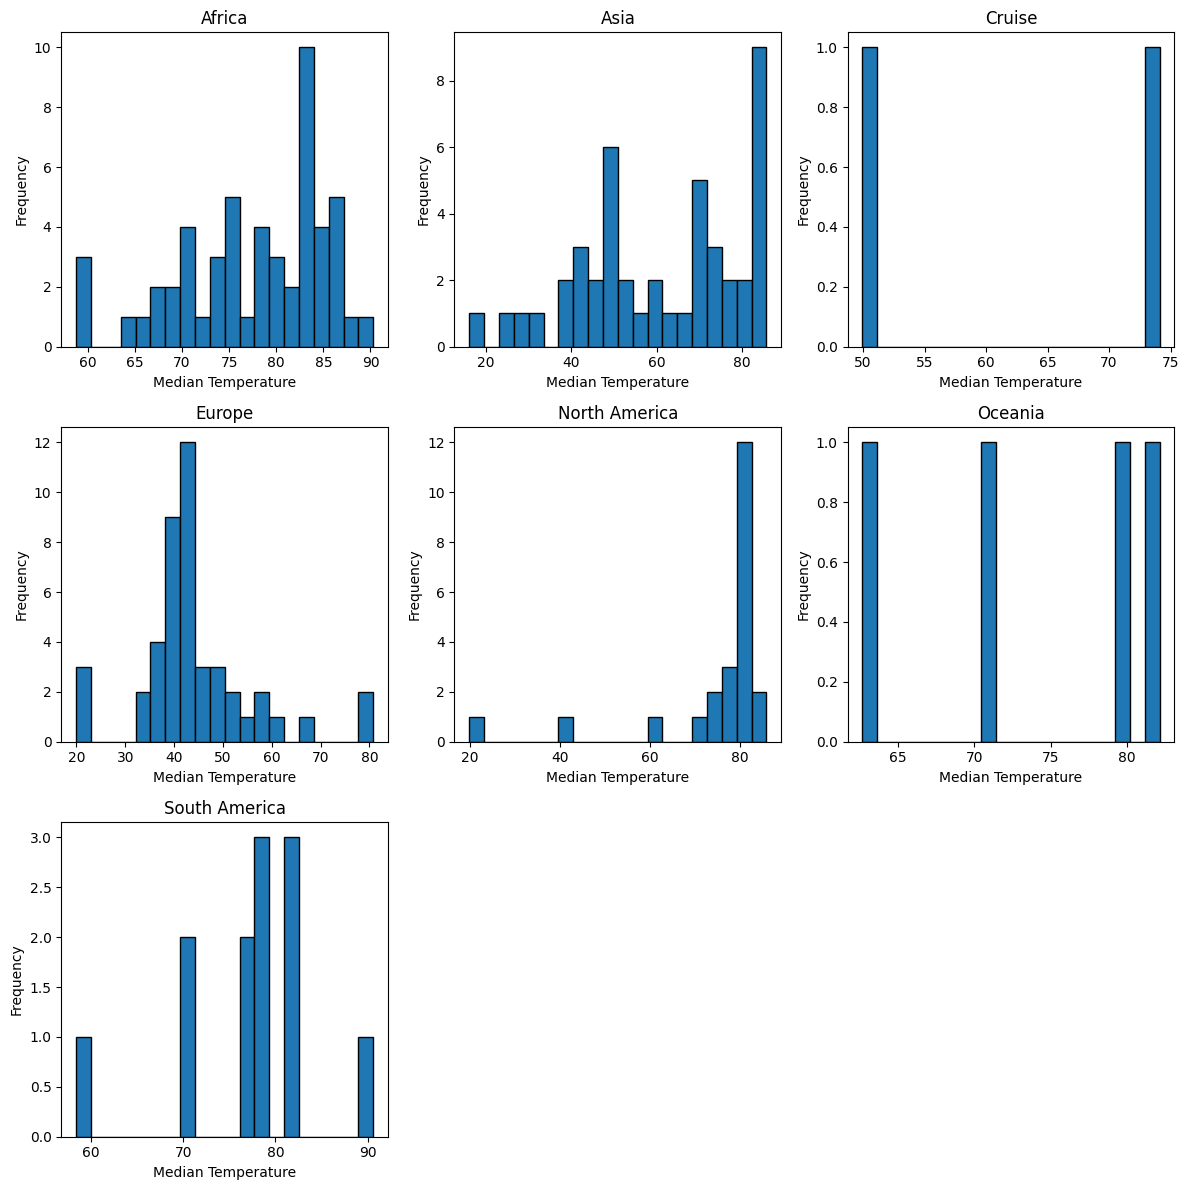

In [58]:
import matplotlib.pyplot as plt

# Adding a 'Continent' column

continent_map_df = pd.read_csv('Continents.csv') #countries and their respective continents

# Median is chosen instead of mean due the size of large countries who may experience different climate
countryByTemperature = df.groupby('Country_Region')['temp'].median()

merged_df = pd.merge(countryByTemperature, continent_map_df, on='Country_Region', how='left')

# Grouping by continent:
grouped_data = merged_df.groupby('Continent')

# Getting the continent names (including Cruise, which makes it seven)
# Africa, Asia, Europe, North America, Oceania, South America, Cruise]
continents_to_plot = list(grouped_data.groups.keys())[:7]

# Creating histograms for the selected continents and cruise:
plt.figure(figsize=(12, 12))
for i, continent in enumerate(continents_to_plot):
    data = grouped_data.get_group(continent)
    plt.subplot(3, 3, i + 1)
    plt.hist(data['temp'], bins=20, edgecolor='black') 
    plt.title(continent)
    plt.xlabel('Median Temperature')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Group by 'Continent' and aggregate mean and std
# continent_stats = merged_df.groupby('Continent')['temp'].agg(['mean', 'std','median'])
# continent_stats = continent_stats.iloc[:7]
# print(continent_stats)

From what we can see in the median temperature of each country, all of them tend to have a major frequency point (aka a mode/peak), likely resembling a bell distribituion more than a uniform distribution, except for Oceania and Cruise.

We see that cumulative cases for high temperature is very low compared to low and and very low temperature

<hr style="fill: 1px solid white;">
<font face="Arial" size="6.5">Histogram of cumulative covid cases vs temperature:</font>

In [59]:
#The cumulative number of confirmed cases per country as of 2020-04-08

date_filtered_df = df[df['Date'] == '2020-04-08']
country_cases = date_filtered_df.groupby('Country_Region')['ConfirmedCases'].sum().reset_index()

countryByTemperatureSD = df.groupby(['Country_Region'])['temp'].agg(['median', 'std'])
merged_df = pd.merge(countryByTemperatureSD, country_cases, on='Country_Region', how='left')

merged_df = merged_df.rename(columns={'median': 'MedianTemperature', 'ConfirmedCases':'CumulativeCases'})

merged_df.sort_values(by='Country_Region')

,Country_Region,MedianTemperature,std,CumulativeCases
0,Afghanistan,38.70,10.830817,444.0
1,Albania,52.65,4.839220,400.0
2,Algeria,70.35,4.207209,1572.0
3,Andorra,34.20,5.388274,564.0
4,Angola,82.90,1.202955,19.0
...,...,...,...,...
179,Vietnam,78.40,3.998495,251.0
180,West Bank and Gaza,50.95,7.989108,263.0
181,Western Sahara,66.25,4.361540,4.0
182,Zambia,71.85,3.427154,39.0


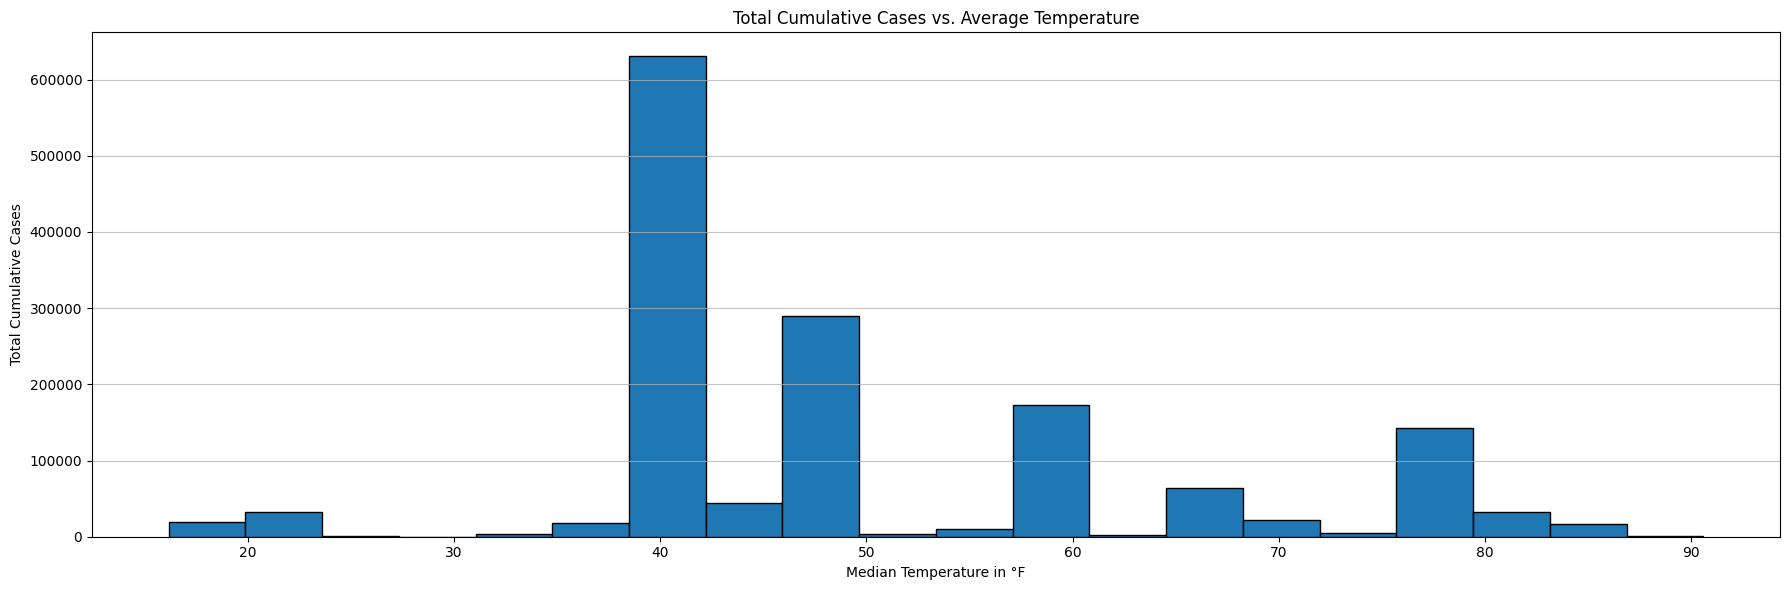

In [161]:
# Using the 'merged_df' dataframe from the previous code bracket with 'Avg.Temperature' and 'CumulativeCases' we can create a histogram with temperature in 
# the horizontal axis and cumulative cases in the vertical axis 

# Defining the temperature bins
bins = pd.interval_range(start=merged_df['MedianTemperature'].min(), end=merged_df['MedianTemperature'].max(), periods=20)  # Adjust 'periods' for the number of bins

# Assigning countries to bins
merged_df['TempBin'] = pd.cut(merged_df['MedianTemperature'], bins=bins)

# Aggregating cases by bin
case_counts_by_bin = merged_df.groupby('TempBin', observed=False)['CumulativeCases'].sum().reset_index()

# Preparing data for plotting
bin_midpoints = [bin.mid for bin in case_counts_by_bin['TempBin']]
case_counts = case_counts_by_bin['CumulativeCases']

# Creating bar plot
plt.figure(figsize=(18, 6))
plt.bar(bin_midpoints, case_counts, width=(bin_midpoints[1] - bin_midpoints[0]), edgecolor='black')

plt.xlabel('Median Temperature in °F')
plt.ylabel('Total Cumulative Cases')
plt.title('Total Cumulative Cases vs. Average Temperature')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

In [160]:
# Getting the highest frequent median temperature interval 
merged_df.groupby('TempBin', observed=False)['CumulativeCases'].sum().idxmax()

Interval(38.48499999999999, 42.207499999999996, closed='right')

<p style="font-size: 16pt">Results: We can see that the majority of covid-19 cases occur in colder temperature countries than in warmer temperature. The highest concentration of covid cases is in countries with median. temperature between 38.49 and 42.21°F (3.61 and 5.67 °C)</p>

In [74]:
# Let's plot the countries with the highest number of covid cases

merged_df[['Country_Region','MedianTemperature','CumulativeCases']].sort_values('CumulativeCases', ascending=False).head(10)

,Country_Region,MedianTemperature,CumulativeCases
171,US,41.70,428889.0
156,Spain,59.60,148220.0
84,Italy,48.35,139422.0
61,France,78.50,113959.0
65,Germany,41.95,113296.0
36,China,47.25,82809.0
80,Iran,48.00,64586.0
175,United Kingdom,66.25,61474.0
170,Turkey,39.10,38226.0
16,Belgium,44.35,23403.0


We can see that the 10 top country with the highest number cases have a temperature floating close to the range of 38.49 to 42.21°F, with France and UK deviating the most. Was these pure coincidence or temperature have an effect of the spread of covid? We will find out by performing <span style="color: yellow">anova testing</span> to determine if there are statistically significant differences in COVID-19 case counts across different temperature ranges.

<hr style="fill: 1px solid white;">
<font face="Arial" size="6.5"> Anova Testing: Comparing Mean Cumulative Covid-19 Cases Across Different Temperature Ranges: </font>
<br> Null Hypothesis (H0): The mean cumulative COVID-19 case are the same accross all the temperature ranges 
<br> Alternative Hypothesis (HA): At least one temperature range has a different mean cumulative COVID-10 cases than the other ranges

In [82]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_copy = df.copy()

# Preprocessing: Replace NaN values in Province_State with the Country_Region value
df_copy['Province_State'] = np.where(df['Province_State'].isnull(), df['Country_Region'], df['Province_State'])

df_provinceState_medianTemperature = df_copy.groupby('Province_State')['temp'].median().reset_index()
df_provinceState_medianTemperature = df_provinceState_medianTemperature.rename(columns={'temp': 'MedianTemperature'})

df_copy = pd.merge(df_copy, df_provinceState_medianTemperature, on='Province_State', how = 'left')

date_filtered_df = df_copy[df_copy['Date'] == '2020-04-08']
provinces_states_cases = date_filtered_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()

provinces_states_medianTemperature = date_filtered_df.groupby('Province_State')['MedianTemperature'].first().reset_index()

merged_provinces_data = pd.merge(provinces_states_cases, provinces_states_medianTemperature, on='Province_State', how='left')

merged_provinces_data = merged_provinces_data.rename(columns={'Province_State': 'Location', 'ConfirmedCases':'CumulativeCases'})

# Dividing the Median Temperature into 4 categories of equal weight
merged_provinces_data['temp_interval'] = pd.qcut(merged_provinces_data['MedianTemperature'], 4, labels=['Very Low', 'Low', 'Medium', 'High'])

model = ols('CumulativeCases ~ temp_interval', data=merged_provinces_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                     sum_sq     df         F    PR(>F)
temp_interval  2.883562e+09    3.0  2.915262  0.034514
Residual       1.015503e+11  308.0       NaN       NaN


The bins are divided according to quantile to ensure that each temp_interval will have enough data points.

We got a p-value of 0.03, which is less than the critical value of 0.05; meaning that if the null hypothesis that the cumulative number of covid cases across temperature were true, there would be only a 3.45% chance of observing the data. This concludes that there is a difference of cumulative cases across temperature. But the question is which of the categories is causing it or whether all of them are different.

Also, the f-statistics is quite high with a value of 2.92, meaning that the difference between groups(temperature) is 2.77 times greater than the difference within groups.

In [75]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Performing multiple t-test to get the p-value for each comparisson

# Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=merged_provinces_data['CumulativeCases'],
                          groups=merged_provinces_data['temp_interval'],
                          alpha=0.05)
print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1  group2   meandiff  p-adj     lower      upper    reject
---------------------------------------------------------------
  High      Low  7767.7051 0.0395    257.0811 15278.3291   True
  High   Medium  2693.2179 0.7908  -4817.4061  10203.842  False
  High Very Low  6281.0256 0.1368  -1229.5984 13791.6497  False
   Low   Medium -5074.4872 0.3021 -12585.1112  2436.1368  False
   Low Very Low -1486.6795 0.9564  -8997.3035  6023.9445  False
Medium Very Low  3587.8077 0.6057  -3922.8163 11098.4317  False
---------------------------------------------------------------


Examining in deeper the comparisons, we can see that we do not reject the null hypothesis for various comparison like low and very low with p-value of 0.96, which we could say that it was not by chance that their distribution were similar. 
<br> 
<br>
We reject the null hypothesis for only high and low temperature interval if we use a critical value of 0.05. However seeing the other comparisons of low and very temperatures we see:
<br>
High and Very low (p-value:0.1368), 
<br>

High and Very low although higher than the benchmark of 0.05, it still shows us evidence that the distribution between high and very low is statistically significantly different. The 0.05 is a conventional number that although very popular should not be used blindly. If we were to choose a higher p-value for the critical value, lets say 0.15, then in this case, we will be able to reject the null hypothesis for high and very low. Having a greater alpha value will allow us to reduce type II errors, which is failing to reject the null hypothesis when it is false. We dont want to miss effects that can affect the spread of the virus, which could delay necessary public health measures or potentially allowing the virus to spread further.

So, we see there is a statistically significant difference in the distribution of cummulative covid case between high and very low, and high and low.

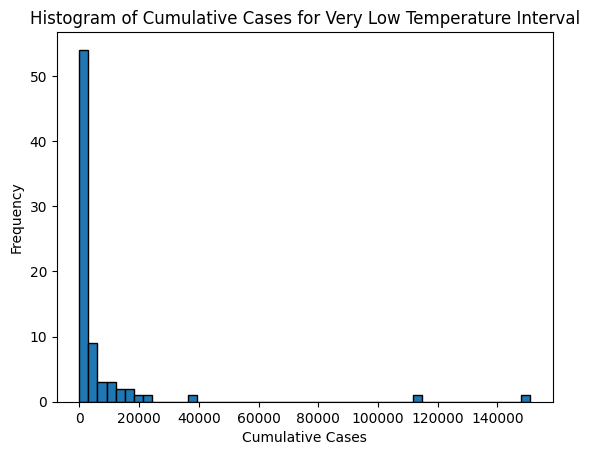

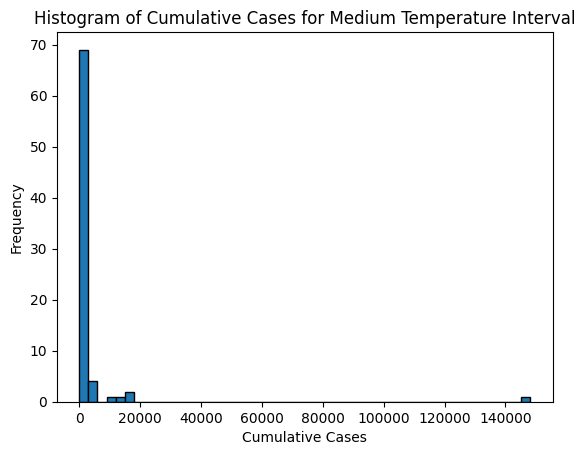

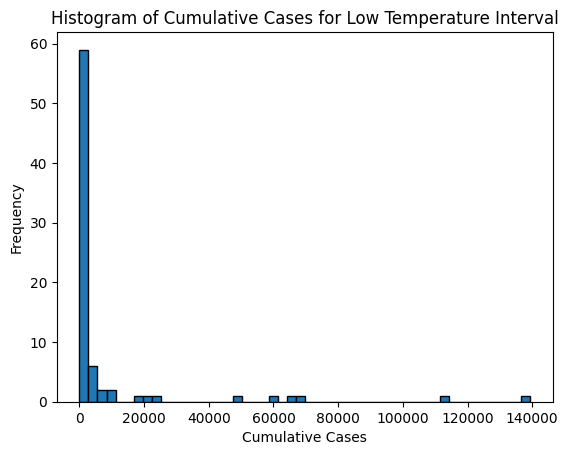

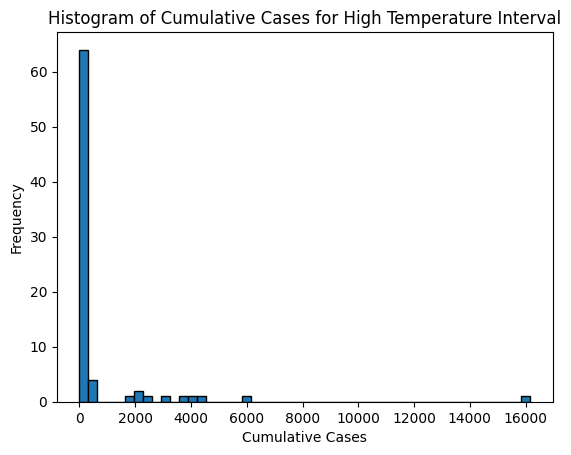

In [46]:
for interval in merged_provinces_data['temp_interval'].unique():
    subset = merged_provinces_data[merged_provinces_data['temp_interval'] == interval]['CumulativeCases']
    plt.figure()  # Create a new figure for each histogram
    plt.hist(subset, bins=50, edgecolor='black')  # Adjust bins as needed
    plt.title(f'Histogram of Cumulative Cases for {interval} Temperature Interval')
    plt.xlabel('Cumulative Cases')
    plt.ylabel('Frequency')
    plt.show()

We see that cumulative cases for high temperature is very low compared to low and and very low temperature

<hr style="fill: 1px solid white;">
<font face="Arial" size="6.5"> Anova Testing: Comparing Mean Cumulative Covid-19 Cases Across Different Continents: </font>
<br> Null Hypothesis (H0): The mean cumulative COVID-19 cases accross continents are the same
<br> Alternative Hypothesis (HA): At least one continent has a different mean cummulative COVID-19 cases compared to the other continents

In [48]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

continent_map_df

df_copy = df.copy()

# Removing cruise from the operation since they dont have enough data points
df_copy = df_copy[~df_copy['Country_Region'].isin(['MS Zaandam', 'Diamond Princess'])]

date_filtered_df = df_copy[df_copy['Date'] == '2020-04-08'].copy()
date_filtered_df['Province_State'] = np.where(date_filtered_df['Province_State'].isnull(), date_filtered_df['Country_Region'], date_filtered_df['Province_State'])

continent_map_df = pd.read_csv('Continents.csv')

merged_df_data = pd.merge(date_filtered_df[['Province_State','Country_Region']], continent_map_df, on='Country_Region', how='left')


provinces_states_cases = date_filtered_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()

merged_df_continent = pd.merge(provinces_states_cases, merged_df_data, on='Province_State', how='left')

# ANOVA using statsmodels
model = ols('ConfirmedCases ~ Continent', data=merged_df_continent).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
print(anova_table)

              df        sum_sq       mean_sq         F    PR(>F)
Continent    5.0  3.824709e+09  7.649418e+08  2.319254  0.043373
Residual   305.0  1.005958e+11  3.298224e+08       NaN       NaN


We can that the F-statistics have a value of 2.32, which tells us that the variance between continents is 2.32 times greater than variance within groups.

With a p-value of 0.04 we reject the null hypothesis if we have a conventional 0.05 as our critical value. Knowing that there are continents that do not have the same mean cumulative covid-19 cases, we have the reason to search deeper.

In [50]:
# Finding the p-values of each comparison permutation
tukey = pairwise_tukeyhsd(endog=merged_df_continent['ConfirmedCases'],
                          groups=merged_df_continent['Continent'],
                          alpha=0.05)
print(tukey)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1        group2     meandiff  p-adj     lower      upper    reject
---------------------------------------------------------------------------
       Africa          Asia  3197.1509 0.9221  -6098.8698 12493.1716  False
       Africa        Europe 10296.5453 0.0238    841.7433 19751.3473   True
       Africa North America  5039.5188 0.6041  -4036.0774 14115.1149  False
       Africa       Oceania     442.06    1.0 -16814.9048 17699.0248  False
       Africa South America  2721.1509 0.9972  -13929.715 19372.0169  False
         Asia        Europe  7099.3944  0.168  -1470.2939 15669.0826  False
         Asia North America  1842.3678 0.9871  -6307.0323  9991.7679  False
         Asia       Oceania -2755.0909 0.9971 -19543.4533 14033.2715  False
         Asia South America     -476.0    1.0 -16640.7027 15688.7027  False
       Europe North America -5257.0266 0.4609 -13587.0926  3073.0395  False
       Europ

Even though we saw a p-value of 0.0433 in the previous code bracket, we see that only the comparisson between Africa and Europe's null hypothesis is rejected with a p-value of 0.0238. As to the other p-values in the table, a majority of them are close to 1 like Africa and South America with p-value of 0.9972 or Oceania and South America with 0.9997. This can attributed to temperature or other environmenta conditions.

<hr style="fill: 1px solid white;">
<font face="Arial" size="6.5">Correlation Analysis: Median Temperature vs. Cumulative Cases</font>

Text(0.5, 1.0, 'Histogram of MedianTemperature')

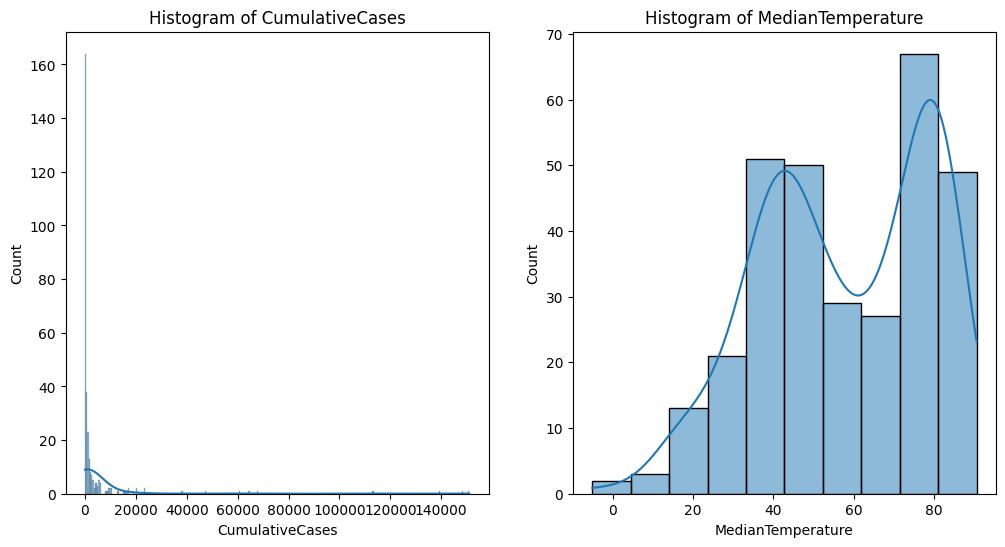

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram for CumulativeCases
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) #First Sublot for histogram for cumulative cases
sns.histplot(merged_provinces_data['CumulativeCases'], kde=True)
plt.title('Histogram of CumulativeCases')

# Histogram for Median Temperature
plt.subplot(1, 2, 2) #Second Sublot for histogram for median temperatures
sns.histplot(merged_provinces_data['MedianTemperature'], kde=True)
plt.title('Histogram of MedianTemperature')

<h4>We can see that CumulativeCases does not follow a normal distribution neither does the cumulative Cases. One shows a bimodal distribution while the other is right/positive skewed, so we went ahead to choose a spearment correlation test</h4>

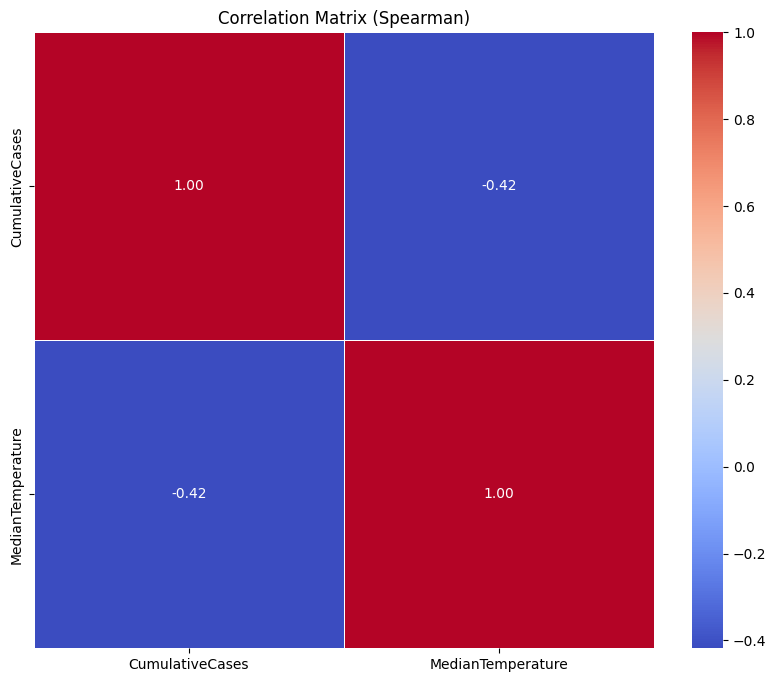

In [93]:
import seaborn as sns

import statsmodels.api as sm

df_copy = df.copy()

# Preprocessing: Replace NaN values in Province_State with the Country_Region value
df_copy['Province_State'] = np.where(df['Province_State'].isnull(), df['Country_Region'], df['Province_State'])

df_provinceState_medianTemperature = df_copy.groupby('Province_State')['temp'].median().reset_index()
df_provinceState_medianTemperature = df_provinceState_medianTemperature.rename(columns={'temp': 'MedianTemperature'})

df_copy = pd.merge(df_copy, df_provinceState_medianTemperature, on='Province_State', how = 'left')

date_filtered_df = df_copy[df_copy['Date'] == '2020-04-08'].copy()
provinces_states_cases = date_filtered_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()

provinces_states_medianTemperature = date_filtered_df.groupby('Province_State')['MedianTemperature'].first().reset_index()

merged_provinces_data = pd.merge(provinces_states_cases, provinces_states_medianTemperature, on='Province_State', how='left')

merged_provinces_data = merged_provinces_data.rename(columns={'Province_State': 'Location', 'ConfirmedCases':'CumulativeCases'})


def plot_correlation(dataframe, method='pearson', annot=True, figsize=(10, 8)):

    # Selecting only the CumulativeCases and Median Temperature columns
    numeric_df = dataframe[['CumulativeCases', 'MedianTemperature']]

    correlation_matrix = numeric_df.corr(method=method)

    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Matrix ({method.capitalize()})')
    plt.show()

# We use spearman correlation since cumulative case and median temperature do not follow a normal distribution
plot_correlation(merged_provinces_data, method='spearman')

From the image, we see a correlation of -0.42, which indicates a moderate negative relationship between the two variables. It tells us that as temperature increases, cumulative cases tend to decrease a vice-versa. 
With a correlation of -0.42, we could say that there is a tendency for locations with higher mean temperatures to have somewhat lower cumulative cases, and locations with lower mean temperatures to have somewhat higher cumulative cases.

<hr style="fill: 1px solid white;">
<font face="Arial" size="6.5"> Anova Testing:Comparing Mean Cumulative Covid-19 Cases Across Different Windspeed Ranges</font>
<br> Null Hypothesis (H0): The mean cumulative COVID-19 cases are the same across all windspeed ranges
<br> Alternative Hypothesis (HA): At least one windspeed range has a different mean cumulative COVID-19 case count compared to the others.

In [102]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_copy = df.copy()

# Preprocessing: Replace NaN values in Province_State with the Country_Region value
df_copy['Province_State'] = np.where(df['Province_State'].isnull(), df['Country_Region'], df['Province_State'])

df_provinceState_medianWindSpeed = df_copy.groupby('Province_State')['wdsp'].median().reset_index()
df_provinceState_medianWindSpeed = df_provinceState_medianWindSpeed.rename(columns={'wdsp': 'MedianWDSP'})

df_copy = pd.merge(df_copy, df_provinceState_medianWindSpeed, on='Province_State', how = 'left')

date_filtered_df = df_copy[df_copy['Date'] == '2020-04-08']
provinces_states_cases = date_filtered_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()

provinces_states_medianWindSpeed = date_filtered_df.groupby('Province_State')['MedianWDSP'].first().reset_index()

merged_provinces_data = pd.merge(provinces_states_cases, provinces_states_medianWindSpeed, on='Province_State', how='left')

merged_provinces_data = merged_provinces_data.rename(columns={'Province_State': 'Location', 'ConfirmedCases':'CumulativeCases'})

# Dividing the Median Temperature into 4 categories of equal weight
merged_provinces_data['windSpeed_interval'] = pd.qcut(merged_provinces_data['MedianWDSP'], 4, labels=['Very Low','Low', 'Medium', 'High'])

model = ols('CumulativeCases ~ windSpeed_interval', data=merged_provinces_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq     df         F    PR(>F)
windSpeed_interval  5.825079e+08    3.0  0.575863  0.631268
Residual            1.038513e+11  308.0       NaN       NaN


We see that it is quiet a high p-value compared to the conventional critical value of 0.05, in which case, we fail to reject the null hypothesis; in other words, windspeed range does not appear to have a statistically significant relationship to the cumulative covid 19 case count.

The F-statistic of 0.575863 is relatively low, which is consistent with the high p-value. A low F-statistic indicates that the variation between the group is small compared to the variation within the groups. The variations between wind range groups is smaller than the variation within each wind range groups.

In conclusion, windspeed intervals do not appear to have a strong influence on cumulative COVID-19 cases. Suggesting that other factors (not windspeed) are likely playing a much larger role in determining cumulative COVID-19 case counts.

In [103]:
# Finding the p-values of each comparison permutation
tukey = pairwise_tukeyhsd(endog=merged_provinces_data['CumulativeCases'],
                          groups=merged_provinces_data['windSpeed_interval'],
                          alpha=0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1  group2   meandiff p-adj    lower      upper    reject
-------------------------------------------------------------
  High      Low 1976.8718 0.9075 -5618.3681  9572.1117  False
  High   Medium 3690.6636 0.5974 -3954.3817 11335.7089  False
  High Very Low 2851.9696 0.7632 -4695.6508 10399.5899  False
   Low   Medium 1713.7918 0.9383 -5931.2535  9358.8371  False
   Low Very Low  875.0978 0.9906 -6672.5226  8422.7182  False
Medium Very Low -838.6941 0.9919  -8436.432  6759.0439  False
-------------------------------------------------------------


<hr style="fill: 1px solid white;">
<font face="Arial" size="6.5"> Anova Testing: Comparing Mean Cumulative Covid-19 Cases Across Different Humidity Ranges</font>
<br> Null Hypothesis (H0): The mean cumulative COVID-19 cases are the same across all humidity ranges
<br> Alternative Hypothesis (HA): At least in one humidity range has a different mean cumulative COVID-19 case count compared to the others.

In [180]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_copy = df.copy()

# Preprocessing: Replace NaN values in Province_State with the Country_Region value
df_copy['Province_State'] = np.where(df['Province_State'].isnull(), df['Country_Region'], df['Province_State'])
df_copy = df_copy.dropna(subset=['ah']) #Dropping rows that do not have a humidity value

df_provinceState_medianHumidity = df_copy.groupby('Province_State')['ah'].median().reset_index()
df_provinceState_medianHumidity = df_provinceState_medianHumidity.rename(columns={'ah': 'MedianHumidity'})

df_copy = pd.merge(df_copy, df_provinceState_medianHumidity, on='Province_State', how = 'left')

date_filtered_df = df_copy[df_copy['Date'] == '2020-04-08']
provinces_states_cases = date_filtered_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()

provinces_states_medianHumidity = date_filtered_df.groupby('Province_State')['MedianHumidity'].first().reset_index()

merged_provinces_data = pd.merge(provinces_states_cases, provinces_states_medianHumidity, on='Province_State', how='left')

merged_provinces_data = merged_provinces_data.rename(columns={'Province_State': 'Location', 'ConfirmedCases':'CumulativeCases'})

# Dividing the Median Temperature into 4 categories of equal weight
merged_provinces_data['MedianHumidity_Intervals'] = pd.qcut(merged_provinces_data['MedianHumidity'], 4, labels=['Very Low','Low', 'Medium', 'High'])
model = ols('CumulativeCases ~ MedianHumidity_Intervals', data=merged_provinces_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                sum_sq     df         F    PR(>F)
MedianHumidity_Intervals  2.378456e+09    3.0  2.363263  0.071267
Residual                  1.019848e+11  304.0       NaN       NaN


In [194]:
import pandas as pd
import numpy as np
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


def fill_ah_with_previous_or_next(data):

    data = data.sort_values(by=['Province_State', 'Date'])  # Sort for correct previous/next access

    for index, row in data.iterrows():
        if pd.isna(row['ah']):
            province = row['Province_State']
            date = row['Date']

            # Find previous value (same province, earlier date)
            previous_row = data[(data['Province_State'] == province) & (data['Date'] < date)].tail(1)
            if not previous_row.empty:
                data.at[index, 'ah'] = previous_row['ah'].values[0]
            else:
                # Find next value (same province, later date)
                next_row = data[(data['Province_State'] == province) & (data['Date'] > date)].head(1)
                if not next_row.empty:
                    data.at[index, 'ah'] = next_row['ah'].values[0]

    return data

df_copy = df.copy()

# Preprocessing: Replace NaN values in Province_State with the Country_Region value
df_copy['Province_State'] = np.where(df_copy['Province_State'].isnull(), df_copy['Country_Region'], df_copy['Province_State'])

# Filling empty values in absolute humidity (ah) with the humidity of either the previous day or next since humidity tends to be relatively stable over short period of times   
df_copy = fill_ah_with_previous_or_next(df_copy)
df_copy = df_copy.dropna(subset=['ah'])

df_provinceState_medianHumidity = df_copy.groupby('Province_State')['ah'].median().reset_index()
df_provinceState_medianHumidity = df_provinceState_medianHumidity.rename(columns={'ah': 'MedianHumidity'})

df_copy = pd.merge(df_copy, df_provinceState_medianHumidity, on='Province_State', how = 'left')

date_filtered_df = df_copy[df_copy['Date'] == '2020-04-08']
provinces_states_cases = date_filtered_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()

provinces_states_medianHumidity = date_filtered_df.groupby('Province_State')['MedianHumidity'].first().reset_index()

merged_provinces_data = pd.merge(provinces_states_cases, provinces_states_medianHumidity, on='Province_State', how='left')

merged_provinces_data = merged_provinces_data.rename(columns={'Province_State': 'Location', 'ConfirmedCases':'CumulativeCases'})

# Dividing the Median Temperature into 4 categories of equal weight
merged_provinces_data['MedianHumidity_Intervals'] = pd.qcut(merged_provinces_data['MedianHumidity'], 4, labels=['Very Low','Low', 'Medium', 'High'])
model = ols('CumulativeCases ~ MedianHumidity_Intervals', data=merged_provinces_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                sum_sq     df         F    PR(>F)
MedianHumidity_Intervals  2.397098e+09    3.0  2.389577  0.068859
Residual                  1.019867e+11  305.0       NaN       NaN


In [195]:
# Finding the p-values of each comparison permutation
tukey = pairwise_tukeyhsd(endog=merged_provinces_data['CumulativeCases'],
                          groups=merged_provinces_data['MedianHumidity_Intervals'],
                          alpha=0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1  group2   meandiff  p-adj     lower      upper   reject
--------------------------------------------------------------
  High      Low -3355.5065 0.6659 -10968.5428 4257.5298  False
  High   Medium -6474.2987 0.1264  -14087.335 1138.7376  False
  High Very Low -6940.0811 0.0866 -14528.6774  648.5152  False
   Low   Medium -3118.7922 0.7151 -10731.8285 4494.2441  False
   Low Very Low -3584.5746 0.6145 -11173.1709 4004.0217  False
Medium Very Low  -465.7824 0.9986  -8054.3787 7122.8139  False
--------------------------------------------------------------


Text(0.5, 1.0, 'Histogram of MedianHumidity')

<Figure size 1200x600 with 0 Axes>

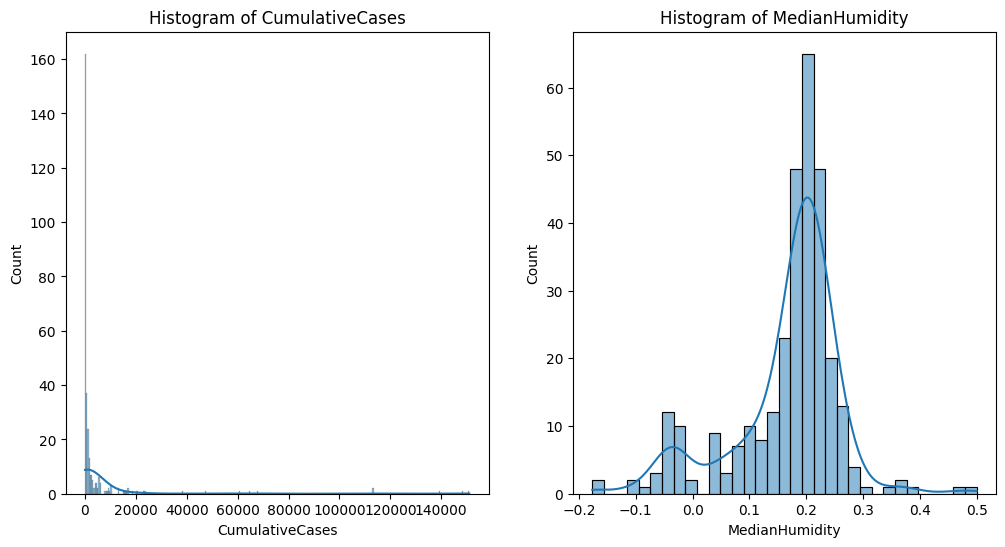

In [190]:
plt.figure(figsize=(12, 6))

# Histogram for CumulativeCases
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) #First Sublot for histogram for cumulative cases
sns.histplot(merged_provinces_data['CumulativeCases'], kde=True)
plt.title('Histogram of CumulativeCases')

# Histogram for Median Humidity
plt.subplot(1, 2, 2) #Second Sublot for histogram for median humidity
sns.histplot(merged_provinces_data['MedianHumidity'], kde=True)
plt.title('Histogram of MedianHumidity')

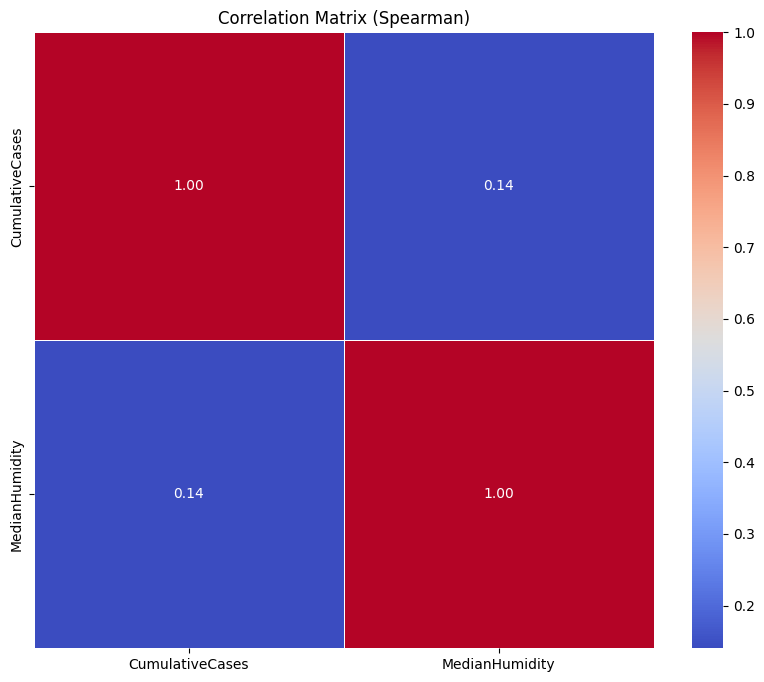

In [191]:
method='spearman'
# Selecting only the CumulativeCases and Median Temperature columns
numeric_df = merged_provinces_data[['CumulativeCases', 'MedianHumidity']]

correlation_matrix = numeric_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix ({method.capitalize()})')
plt.show()